
# **EMOTIONAL SPEECH RECOGNITION ANALYSIS**

## English
El siguiente analisis presenta una clasificacion emocional del discurso, reconociendo 7 emociones (enfado, sorpresa, asco, miedo, felicidad, tristeza y neutral) para el idioma **inglés**.

Luisa Sanchez Avivar
    _luisasanavi@gmail.com_

In [6]:
# IMPORT LIBRARIES
# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Files
import os

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile



In [7]:
AUDIO_DATA_PATH = 'data/RAVDESS/'
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'
SAMPLE_FILE = "03-01-01-01-01-01-01.wav"

# Maps
EMOTION_MAP = {1:'neutral', 2:'calma', 3:'felicidad', 4:'tristeza', 5:'enfado', 6:'miedo', 7:'asco', 8:'sorpresa'}
INTENSITY_MAP = {1:'normal', 2:'strong'}


## **1. CARGA DE DATOS**
Para este analisis utilizare el dataset de [RAVDESS](https://zenodo.org/record/1188976.) (Ryerson Audio-Visual Database of Emotional Speech and Song), el cual contiene 7356 archivos (24.8 GB) entre los cuales podemos encontrar 3 modalidades: **solo audio** (en 16 bit, 48 kHz y en formato .wav), **audio-video** (720p H.264, AAC 48kHz, .mp4) y **solo video** sin sonido.





In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
dir_list = os.listdir(GPATH + AUDIO_DATA_PATH)
dir_list.sort()

print(dir_list)

emotion = []
gender = []
intensity = []
path = []

# Extraemos de cada archivo de sonido sus datos
for dir in dir_list:
  path_dir = os.listdir(GPATH + AUDIO_DATA_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filepath in path_dir:
    info_vector = filepath.split('.')[0].split('-')
    n_emotion = int(info_vector[2])
    n_gender = int(info_vector[6])
    n_intensity = int(info_vector[3])
    str_path = GPATH + AUDIO_DATA_PATH + dir + '/' + str(filepath)
    path.append(str_path)
    emotion.append(n_emotion)
    intensity.append(n_intensity)
    if n_gender%2 == 0:
      gender.append('female')
    else:
      gender.append('male')

# Construimos el data frame
EnglishSpeech_df = pd.DataFrame(columns=['emotion', 'gender', 'intensity', 'path'])
EnglishSpeech_df['emotion'] = emotion
EnglishSpeech_df['gender'] = gender
EnglishSpeech_df['intensity'] = intensity
EnglishSpeech_df['path'] = path
EnglishSpeech_df['emotion'] = EnglishSpeech_df['emotion'].map(EMOTION_MAP) 
EnglishSpeech_df['intensity'] = EnglishSpeech_df['intensity'].map(INTENSITY_MAP)


print("Size of the dataset: {} \n".format(len(EnglishSpeech_df)))
class_distribution = EnglishSpeech_df['emotion'].value_counts()
print(class_distribution)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
Size of the dataset: 1440 

enfado       192
calma        192
sorpresa     192
tristeza     192
miedo        192
asco         192
felicidad    192
neutral       96
Name: emotion, dtype: int64


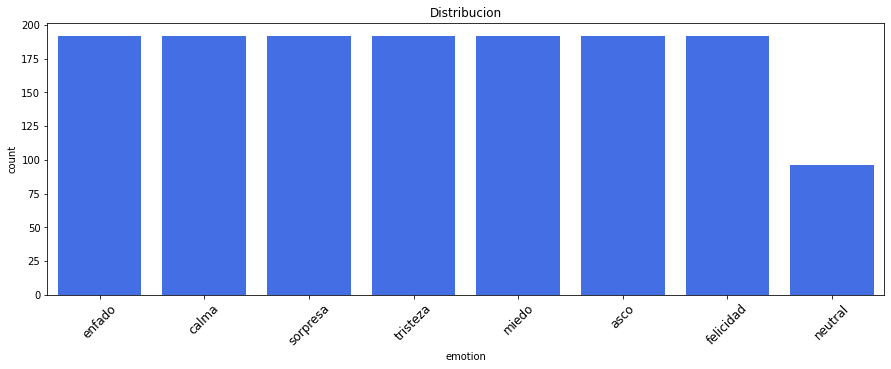

In [10]:
# Imprimimos la distribucion de las clases

df_aux = pd.DataFrame()
df_aux['emotion'] = list(class_distribution.keys())
df_aux['count']  = list(class_distribution)
fig, axs = plt.subplots(figsize=(15, 5))
axs = sns.barplot(x = 'emotion', y = 'count', color = '#2962FF', data = df_aux)
axs.set_title('Distribucion')
axs.set_xticklabels(axs.get_xticklabels(),rotation=45, fontsize = 12)
plt.show()

In [11]:
# Imprimimos una muestra de 10 filas aleatorias
EnglishSpeech_df.sample(n = 10)

,emotion,gender,intensity,path
156,miedo,male,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
114,sorpresa,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
437,felicidad,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
256,felicidad,male,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
655,sorpresa,male,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
671,felicidad,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
1423,enfado,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
1056,enfado,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
1382,neutral,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
542,calma,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...


# **2. EXPLORACION DE LOS DATOS**

### **2.1 EXPOSICION DE UNA MUESTRA ALEATORIA**



In [12]:

def plot_audio_waveform(audio_sample):
  '''
  Muestra la forma de la onda sonora a partir de una muestra.

  Arguments
  ---------
  audio_sample: dataFrame
    Muestra de audio 
  
  '''
  sample, sampling_rate = librosa.load(audio_sample)
  plt.figure(figsize=(12, 4))
  librosa.display.waveplot(sample, sr=sampling_rate)
  print(len(sample))
  

def log_specgram(audio_sample):
  '''
  Muestra el espectograma a partir de una muestra de audio

  Arguments
  ---------
  audio_sample: dataFrame
    Muestra de audio
  '''
  sample, sampling_rate = librosa.load(audio_sample)
  return  __log_specgram(sample, sampling_rate)


def __log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
  '''
  Imprime el especograma de una muestra de audio en una ventana de tiempo
  
  Arguments
  ---------
  audio: np.ndarray
    Muestra de audio
  sample_rate: int, optional
    Frecuencia de muestreo de la muestra de audio
  window_size: int, optional

  step_size: int, optional
  
  eps: int, optional
  '''
  nperseg = int(round(window_size * sample_rate / 1e3))
  noverlap = int(round(step_size * sample_rate / 1e3))
  freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
  return freqs, times, np.log(spec.T.astype(np.float32) + eps)


Random audio sample: /content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/data/RAVDESS/Actor_05/03-01-08-01-01-02-05.wav
80931


Text(0, 0.5, 'Hz')

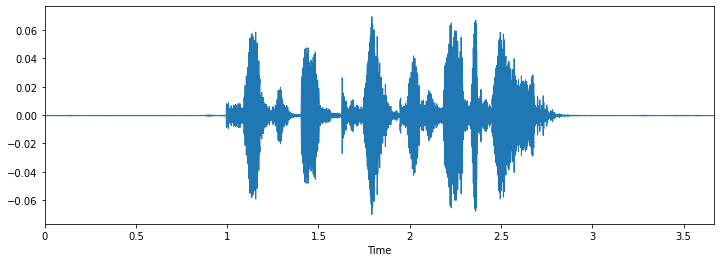

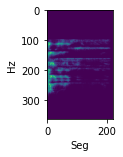

In [13]:
random_sample = EnglishSpeech_df.path[random.randint(0, len(EnglishSpeech_df))]
print("Random audio sample: {}".format(random_sample))
# Dibuja la grafica de la onda sonora
plot_audio_waveform(random_sample)

# Dibuja el espectograma
freqs, times, spectrogram = log_specgram(random_sample)

# Muestra la firgura
plt.figure(figsize=(30, 2))
plt.imshow(spectrogram)
plt.xlabel('Seg')
plt.ylabel('Hz')

In [14]:

# samplingFrequency, signalData = wavfile.read(random_sample)
# plt.plot(sample)
# plt.specgram(sample, Fs=sampling_rate)

### **2.2 COMPARATIVA DE TODAS LAS EMOCIONES**
Ahora que hemos conseguido extraer la grafica de una determinada muestra de sonido, vamos a comparar la graficas correspondientes a las muestras de sonido de distintas emociones respectivamente. Para ello vamos a distinguir por genero, ya que podria suponer una diferencia.

In [15]:
def plot_all_emotion_waveforms(gender, rows = 3, cols = 3):
  '''
  Muestra los graficos para todas las emociones con su correspondiente 
  etiqueta del dataset para un mismo genero (female/ male)
  
  Arguments
  --------- 
    gender: str
      Genero del actor en el audio
    rows:  int, optional
      Filas en las que se muestra. 5 por defecto
    cols: int, optional
      Columnas en las que se muestra. 2 por defecto
    
  '''
  labels = list(EnglishSpeech_df['emotion'].unique())
  files = dict()
  if not gender:
    return -1

  # Seleccionamos una muestra aleatoria correspondiente a cada emocion
  for label in labels:
    # Escogemos un archivo de audio al azar que cumpla estas dos condiciones
    index = EnglishSpeech_df[(EnglishSpeech_df['emotion'] == label) & 
                            (EnglishSpeech_df['gender'] == gender)].sample(n = 1).index[0]
    emotion_file = EnglishSpeech_df.iloc[index].path
    files[label] = emotion_file

  # Mostramos las diferentes waveforms
  fig = plt.figure(figsize=(15,15))
  fig.subplots_adjust(hspace=1, wspace=0.4)
  for i, label in enumerate(labels):
    wfigure = files[label]
    fig.add_subplot(rows, cols, i+1)
    plt.title(label.capitalize())
    data_sample, sample_rate = librosa.load(wfigure)
    librosa.display.waveplot(data_sample, sr= sample_rate)

    ## TODO: return image figure


### 2.2.1 COMPARATIVA DE EMOCIONES PARA HOMBRE
En primer lugar vemos que aspecto tienen las emociones para la **voz masculina**

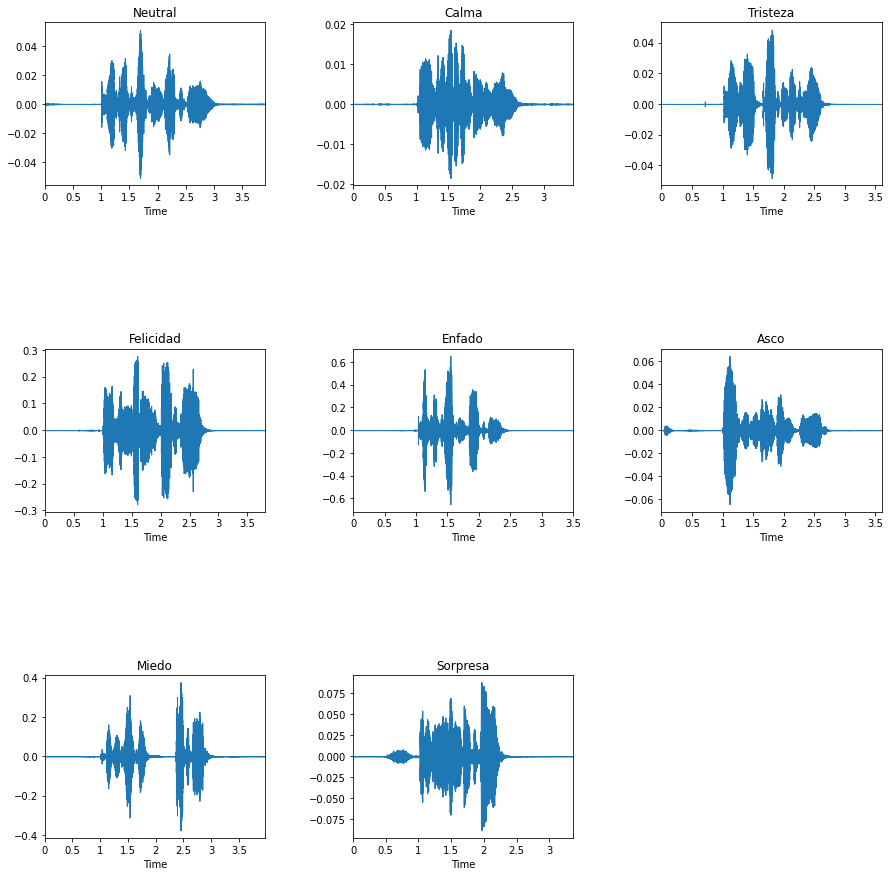

In [16]:
plot_all_emotion_waveforms('male')


### 2.2.2 COMPARATIVA DE EMOCIONES DE MUJER
Vemos el aspecto que tienen las emociones para la **voz femenina**


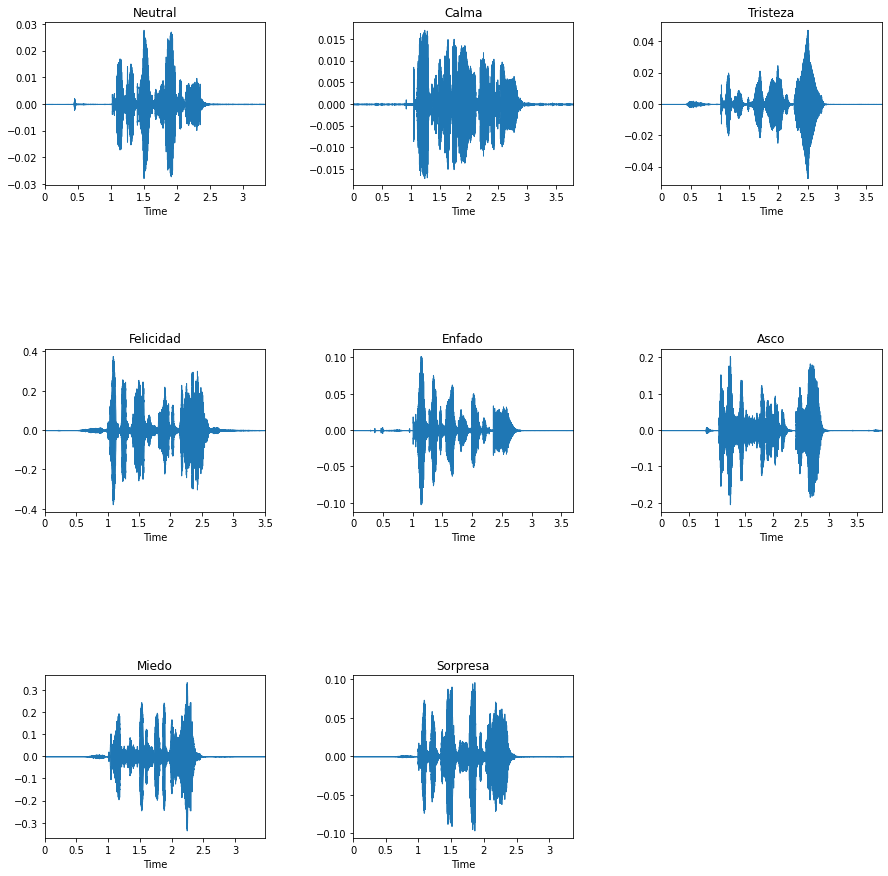

In [17]:
plot_all_emotion_waveforms('female')

Se puede observar en los resultados, que la se;al asociada a cada una de las emociones presenta diferencias con respecto a la voz femenina y la masculina. A simple vista no podemos hablar de unos cambios constantes en determinados puntos. Vemos que la *felicidad* masculina y femennina es expresada de una manera similar, al contrario, por ejemplo, de lo que ocurre con el *miedo*, donde en su version masculina presenta mas saltos entre sus picos de frecuencia. por lo que es algo que deberemos tener en cuenta en este analisis

# **3. EXTRACCION DE CARACTERISTICAS**

### **3.1 EXTRACCION DE CARACTERISTICAS CON MFCC**

In [18]:
def get_features(df):
  '''
  Extrae las caracteristicas de un conjunto de pistas de audio a 
  partir de un dataframe usando librosa

  Aguments
  ---------
    df : dataframe
    Dataframe que contiene el path donde se encuentra la pista de audio

  Return
  -------
   data: np.array 
   Caracteristicas extraidas

  '''
  bar_data_range = tqdm(range(len(df)))
  data = pd.DataFrame(columns = ['data'])
  for index in bar_data_range:
    data_features = get_features_single_file(df.path[index])
    data.loc[index] = [data_features]

  return data


def get_features_single_file(pathfile):
  '''
  Extrae las caracteristicas  de una unica pista de audio usando MFCC 
  a traves de librosa.
  
  Aguments
  ---------
    pathfile: str 
      Path del archivo del que se extraeran las caracteristicas

  Return
  -------
    data_features

  '''
  X, sample_rate = librosa.load(pathfile, duration=2.5, sr=22050*2, offset=0.5)
  mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
  data_features = np.mean(mfcc, axis = 0)

  return data_features



def get_random_emotion(df, emotion):
  '''
  Devuelve el path de un archivo de audio aleatorio a partir de un dataframe.

  Aguments
  ---------
  df: dataframe
    Caracteristicas de la muestra de audio organizadas por emociones
  emotion: str
    Nombre de la emocion 
    
  Return
  -------
  '''
  if 'emotion' not in df:
    return -1

  aux_df = df[df['emotion'] == emotion]
  item = random.choice(aux_df.index.to_list())
  path = aux_df.path[item]

  return path

def plot_waves_comparative(df1, df2, df1_title = 'Wave 1', df2_title = 'Wave 2', title_ = 'Title'):
  '''
  Imprime la grafica de dos waveforms a partir de sus caracteristicas.

  Aguments
  ---------
  df1: dataframe
    Caracteristicas de la primera muestra de audio
  df2: dataframe
    Caracteristicas de la segunda muestra de audio
  df1_title: str, optional
    Titulo para la primera grafica
  df2_title: str, optional
    Titulo para la segunda grafica 
  title_: str, optional
    Titulo para la figura

  '''
  plt.figure(figsize=(20, 15))
  plt.subplot(3,1,1)
  plt.title(title_)
  plt.plot(df1, label= df1_title)
  plt.plot(df2, label= df2_title)
  plt.legend()


def plot_all_comparative_waveforms(rows = 3, cols = 3):
  '''


  Aguments
  ---------
  Return
  -------
  '''

  labels = list(EnglishSpeech_df['emotion'].unique())
  features_dict = dict()
  for label in labels:
    # Female
    path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'female'], label)
    # female_feat = get_features_single_file(path)
    key = 'female_' + label
    features_dict[key] = get_features_single_file(path)
    # Male
    path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'male'], label)
    # male_feat = get_features_single_file(path)
    key = 'male_' + label
    features_dict[key] = get_features_single_file(path)

  # Mostramos las diferentes waveforms
  fig = plt.figure(figsize=(15,15))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  for i, label in enumerate(labels):
    key = 'female_' + label
    df_fem = features_dict[key]
    key = 'male_' + label
    df_mal = features_dict[key]
    fig.add_subplot(rows, cols, i+1)
    plt.title(label)
    plt.plot(df_fem, label= 'female')
    plt.plot(df_mal, label= 'male')
    plt.legend()



In [19]:
# Guardamos las caracteristicas a partir de la estructura que hemos construido antes
features_data = get_features(EnglishSpeech_df)
print(features_data)

100%|██████████| 1440/1440 [19:35<00:00,  1.22it/s]

                                                   data
0     [-66.059105, -66.059105, -66.059105, -66.05910...
1     [-73.84225, -73.84225, -73.84225, -73.72053, -...
2     [-61.85075, -62.89586, -63.831463, -60.553463,...
3     [-70.26854, -70.26854, -70.26854, -70.26854, -...
4     [-69.05201, -69.05201, -69.05201, -69.05201, -...
...                                                 ...
1435  [-59.850037, -59.850037, -59.850037, -59.85003...
1436  [-58.232124, -58.232124, -58.232124, -58.23212...
1437  [-56.9414, -56.9414, -56.9414, -56.9414, -56.9...
1438  [-48.669613, -45.722324, -46.04846, -46.527206...
1439  [-55.255962, -55.255962, -55.187458, -55.34609...

[1440 rows x 1 columns]


In [20]:
# features_data.head()
f_df = pd.DataFrame(features_data['data'].values.tolist())
f_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-65.682808,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-65.751534,-63.380966,-62.700752,-65.098381,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.002815,-61.924988,-59.585251,-56.340050,-54.956478,-55.591431,...,-55.764549,-58.545471,-55.988743,-56.975449,-61.780460,-65.383774,-63.935688,-63.328606,-62.011509,-61.251255,-62.367161,-62.563297,-61.352036,-63.539749,-64.852814,-61.058853,-60.734673,-62.970982,-65.925476,-66.059105,-66.059105,-65.233574,-64.616928,-65.550819,-66.059105,-66.059105,-65.296371,-61.711594,-60.360741,-60.373734,-57.540462,-55.827206,-57.742855,-59.797207,-60.976192,-62.663845,-64.574211,-63.783470,-61.517021,-58.217075
1,-73.842247,-73.842247,-73.842247,-73.720528,-73.842247,-73.842247,-73.842247,-73.304657,-72.807800,-73.842247,-73.842247,-73.318672,-65.748177,-64.292671,-63.901077,-62.007446,-61.668205,-60.353573,-62.795673,-71.039787,-67.588890,-70.090088,-71.926071,-72.205902,-73.842247,-71.767052,-69.865593,-65.621536,-62.510490,-60.178303,-61.991924,-64.299286,-65.288956,-67.775200,-66.402573,-64.903633,-62.787174,-58.825623,-54.061951,-53.111855,...,-30.143034,-30.706505,-30.394371,-29.729404,-30.308889,-29.539310,-30.008671,-29.881319,-30.892702,-33.100491,-30.836924,-30.755800,-30.185331,-31.663187,-33.846001,-34.118858,-36.499855,-38.370602,-39.913235,-41.742886,-42.856297,-43.770603,-44.719074,-45.199142,-46.888340,-48.836185,-49.847420,-49.986946,-49.796787,-51.918861,-51.597122,-50.530499,-53.475498,-54.207867,-51.526096,-52.561081,-54.772148,-56.335018,-57.500893,-56.567909
2,-61.850750,-62.895859,-63.831463,-60.553463,-60.822613,-62.074265,-64.890053,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-63.680496,-59.563381,-59.069218,-62.143883,-62.432308,-64.842644,-65.390717,-65.390717,-63.870674,-61.361370,-59.707901,-59.798950,-62.271980,-60.550758,-58.221989,-58.359535,-60.649246,-53.255680,-51.225761,-49.681644,-51.877785,-56.027061,-57.659988,-58.432919,-58.608315,-60.930626,-64.419708,-58.210060,...,-53.209366,-54.153305,-52.783730,-53.129257,-57.196308,-55.771366,-55.110691,-57.924313,-56.827610,-57.973213,-56.144112,-53.264206,-55.031013,-58.032761,-62.374447,-63.339924,-59.325741,-58.808514,-62.785091,-63.299229,-63.523270,-64.284760,-64.732941,-61.391403,-60.566311,-61.249634,-64.318771,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717
3,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.001549,-69.981659,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-66.097252,-63.398201,-68.260742,-70.268539,-69.666077,-68.817963,-66.116409,-63.903828,-68.622383,-70.268539,-69.642830,-68.421051,-70.044975,-67.233437,-66.351326,-68.504265,-66.578323,-62.981785,-62.694344,-65.907471,...,-40.011742,-39.581402,-41.080826,-41.835026,-43.329956,-44.811626,-46.607578,-45.475891,-48.727745,-51.779503,-51.438679,-52.644341,-54.618233,-56.557270,-56.229717,-53.642990,-52.772163,-51.569214,-54.047665,-55.942867,-54.383808,-54.098572,-52.374531,-51.011082,-53.335392,-55.216549,-57.184219,-60.705837,-57.998859,-57.543839,-58.802940,-57.448360,-58.897434,-58.751919,-57.406570,-60.079292,-63.427677,-62.639439,-61.083599,-60.235447
4,-69.052010,-69.052010,-69.052010,-69.052010,-69.052010,-68.755501,-69.052010,-69.052010,-69.052010,-68.359833,-68.879417,-69.052010,-68.494072,-67.110680,-66.995140,-68.018822,-66

In [21]:
features_complete_df = pd.concat((f_df, EnglishSpeech_df['gender'], EnglishSpeech_df['emotion']), axis = 1)
features_complete_df = features_complete_df.fillna(0)

# Barajamos las filas para imrpimir una muestra 
random_aux = shuffle(features_complete_df)
random_aux.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,gender,emotion
909,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.249630,-56.674503,-56.720871,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.254391,-57.253868,-56.648823,-56.476494,-56.896458,-56.489300,...,-33.077309,-33.460697,-34.671196,-34.029701,-33.811237,-33.949074,-34.162102,-37.536427,-39.896896,-40.612076,-39.051720,-39.450932,-41.159317,-41.148502,-42.496357,-44.697861,-46.926540,-49.264385,-49.350891,-49.207886,-49.541286,-49.393719,-50.286026,-52.471191,-51.966305,-51.418083,-53.368671,-54.650108,-53.807327,-53.685715,-56.109562,-56.329777,-55.371574,-53.754311,-54.155197,-56.822388,-56.579990,-55.382900,female,felicidad
312,-50.699600,-51.762188,-53.458134,-53.338661,-52.889969,-52.884480,-53.077110,-53.880230,-55.146744,-55.437157,-55.874630,-55.560360,-55.189846,-55.987740,-56.118889,-54.366653,-53.378296,-53.279110,-51.541119,-52.817307,-54.540195,-52.973579,-52.717918,-54.770126,-56.955349,-55.968193,-56.699856,-57.619175,-57.317036,-55.468784,-52.810001,-53.211651,-55.276443,-56.301811,-57.089924,-57.286907,-59.446735,-59.305256,-57.176208,-57.170349,...,-44.177654,-42.736404,-42.533504,-42.556290,-44.064106,-43.835018,-42.733658,-43.796085,-45.132954,-45.832554,-45.232971,-44.997707,-46.328182,-45.680683,-46.330997,-45.461815,-46.884197,-48.092949,-47.533894,-46.656471,-47.183674,-48.062508,-47.875698,-49.059734,-50.262630,-51.742519,-53.188869,-51.801739,-53.103634,-55.088112,-56.179752,-56.458755,-56.671280,-55.778358,-57.406113,-56.879841,-54.409733,-54.666348,female,felicidad
1304,-53.813370,-55.475224,-58.206181,-57.841614,-57.815712,-58.517246,-58.542809,-56.029461,-54.090000,-55.359047,-58.424198,-58.683418,-58.683418,-58.481400,-55.896091,-53.780861,-53.825142,-55.010151,-56.751034,-58.520897,-58.501896,-57.058907,-54.561588,-53.958492,-54.591717,-55.719048,-57.730976,-58.512840,-58.683418,-58.683418,-58.683418,-58.567280,-58.631859,-58.683418,-58.683418,-58.683418,-58.683418,-58.683418,-58.534969,-57.713299,...,-47.352196,-49.083401,-49.432640,-47.717453,-43.757328,-42.544449,-43.131287,-41.411362,-40.204891,-37.340824,-34.553185,-34.436703,-34.058346,-35.492828,-34.934566,-36.913765,-38.168961,-38.722446,-39.410500,-38.107430,-37.242615,-36.835670,-36.017757,-36.920124,-37.569191,-37.230820,-37.712654,-37.716854,-36.093719,-35.525993,-37.862518,-37.124443,-35.995327,-36.470413,-34.390522,-32.849503,-26.104092,-20.809788,female,asco
798,-47.939739,-47.939739,-47.939739,-47.939739,-47.939739,-47.939739,-47.939739,-47.939739,-47.939739,-47.939739,-47.939739,-48.055153,-48.390713,-48.444511,-48.891960,-49.473087,-48.573067,-47.603378,-47.697395,-47.808537,-47.198898,-47.466614,-45.276688,-44.715279,-46.207054,-46.768509,-46.155109,-46.096947,-45.375359,-44.562386,-45.959446,-46.550068,-48.622898,-48.791950,-49.066753,-49.062950,-49.793453,-49.133064,-48.221138,-47.768944,...,-38.791832,-39.262661,-42.127583,-44.666527,-45.109680,-40.629997,-37.875038,-35.876732,-33.762661,-33.561832,-33.573872,-32.333267,-31.273109,-28.326586,-28.899431,-29.213001,-29.368767,-30.485270,-32.684185,-30.078417,-27.208376,-27.594637,-28.976290,-31.427647,-33.533112,-34.078171,-35.323002,-36.094963,-35.936447,-39.218102,-41.337212,-43.327888,-44.895634,-46.342342,-46.352077,-46.122883,-45.831833,-45.532574,female,felicidad
536,-58.593670,-58.231968,-55.636238,-55.270138,-56.137371,-57.638592,-58.219078,-58.391472,-58.593670,-58.593670,-58.593670,-58.593670,-58.593670,-58.593670,-58.593670,-58.571510,-58.593670

#### Division del dataframe
Vamos a dividir el dataframe por el genero, para comprobar como afecta este a la prosodia en la voz femenina y masculina por separadas, dadas las mismas emociones en el analisis

In [24]:
male_features_df = features_complete_df[(features_complete_df['gender'] == 'male')]
female_features_df = features_complete_df[(features_complete_df['gender'] == 'female')]

#### Comparativa
Ahora que podemos extraer las caracteristicas de las señales, vamos a comparar la misma emocion, (por ejemplo *enfado*) en la voz femenina y la masculina.


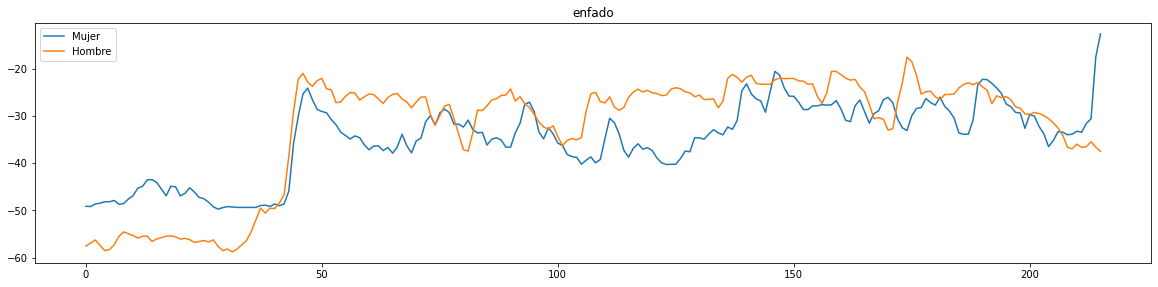

In [27]:
# Extraemos una muestra aleatoria para la emocion: enfado 
# Female
path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'female'], 'enfado')
female_feat = get_features_single_file(path)
# print(len(female_feat))
# Male
path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'male'], 'enfado')
male_feat = get_features_single_file(path)
# print(len(male_feat))

plot_waves_comparative(female_feat, male_feat, "Mujer", "Hombre", "enfado")



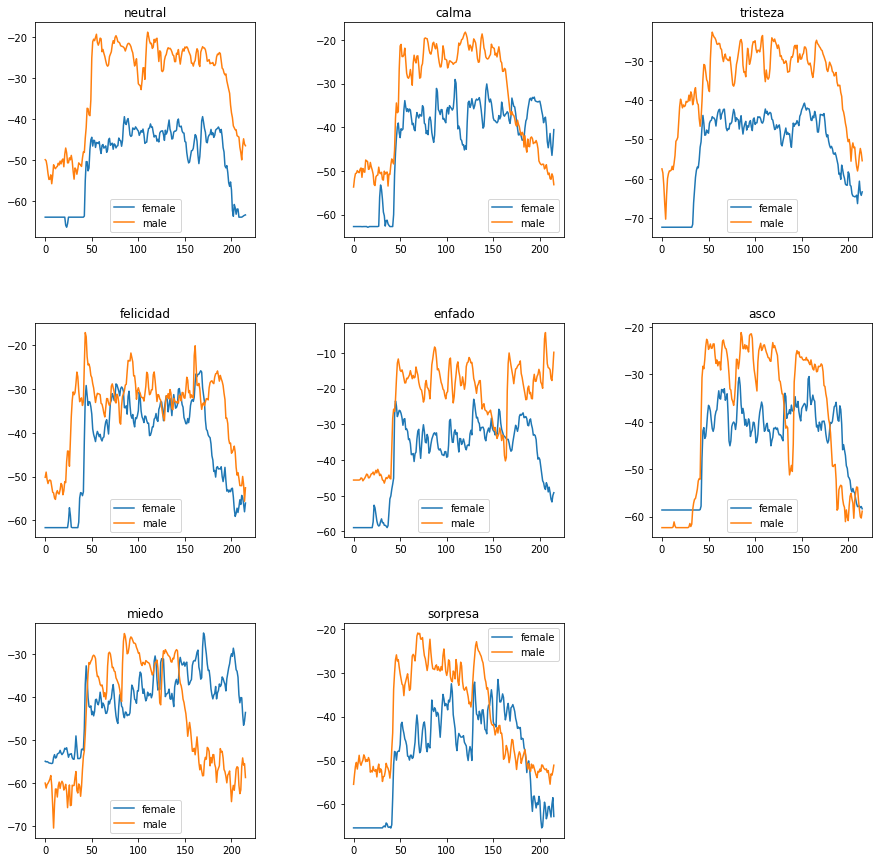

In [28]:
plot_all_comparative_waveforms()

### **3.2 PREPARACION DE LOS DATOS**


In [29]:
def split_training_test(df, n_splits_=1, test_size_=0.25, train_size_=None):
  '''
  Divide el dataset en entrenamieto y test utilizando StratifiedShuffleSplit
  Aguments
  ---------
  Return
  -------
  '''
  X = df.drop(['gender', 'emotion'], axis=1)
  Y = df.emotion
  test_train_stratified = StratifiedShuffleSplit(n_splits = n_splits_, test_size = test_size_, random_state=12)
  for train_index, test_index in test_train_stratified.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

  return X_train, X_test, Y_train, Y_test
  # return train_test_split(X, Y, stratify = Y, test_size=0.25)#X_train, X_test, Y_train, Y_test


def data_normalization(val_train, val_test):
  '''
  Normaliza los datos mejorando la precision y la velocidad del proceso de entrenamiento
  Aguments
  ---------
  Return
  -------
  '''
  mean = np.mean(val_train, axis=0)
  std = np.std(val_train, axis=0)

  X_train = (val_train - mean)/std
  X_test = (val_test - mean)/std

  return X_train, X_test


def data_to_categorical(x_train_norm, y_train, x_test_norm, y_test):
  '''
  Categoriza los datos y los formatea para su uso con keras. Asume que x_train y x_test estan normalizados.
  Aguments
  ---------
  Return
  -------
  '''
  # Preparamos los datos para la categorizacion
  x_train_norm = np.array(x_train_norm)
  y_train = np.array(y_train)
  x_test_norm = np.array(x_test_norm)
  y_test = np.array(y_test)

  # One hot encode 
  label_encoder = LabelEncoder()
  y_train = np_utils.to_categorical(label_encoder.fit_transform(y_train))
  y_test = np_utils.to_categorical(label_encoder.fit_transform(y_test))

  # filename = 'labels'
  # outfile = open(filename,'wb')
  # pickle.dump(label_encoder, outfile)
  # outfile.close()

  # print(x_train_norm.shape)
  # print(label_encoder.classes_)

  return x_train_norm, y_train, x_test_norm, y_test, label_encoder



#### 3.2.1 DIVISION DE LOS DATOS EN ENTRENAMIENTO Y TEST

In [30]:
# NOTA: Aqui estoy comprobando los datos que me da si divido entrenamiento y test con split de toda la vida

# # female_X_train, female_X_test, female_Y_train, female_Y_test =split_training_test(female_features_df)
# female_X_train.head()
# print(918 in female_X_train.index)

In [31]:
X_train, X_test, Y_train, Y_test = split_training_test(features_complete_df)
X_train.head()
print(X_train.shape)

(1080, 216)


In [32]:
# Comprobamos la distribución de las clases (emociones en nuestro caso)
Y_train.value_counts()

sorpresa     144
enfado       144
tristeza     144
miedo        144
asco         144
felicidad    144
calma        144
neutral       72
Name: emotion, dtype: int64

In [33]:
# Comprobamos que no hay valores NaN
X_train.isna().sum().sum()

0

#### 3.2.2 NORMALIZACION DE LOS DATOS


In [34]:
X_train_norm, X_test_norm = data_normalization(X_train, X_test)
print(features_complete_df.shape)

# Comprobamos imprimiendo una muestra de los datos
indx = random.randint(0, len(features_complete_df))
X_train[indx:indx+10]

(1440, 218)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
214,-56.483047,-56.483047,-56.483047,-56.500778,-56.486694,-56.521061,-56.483047,-56.483047,-56.483047,-56.483047,-56.483047,-56.483047,-56.483047,-56.483047,-56.483047,-56.483047,-56.483047,-56.483047,-56.501553,-56.638634,-56.449131,-56.588745,-55.513489,-53.076412,-52.395004,-48.787643,-45.117310,-40.912312,-37.853077,-37.462112,-38.525009,-40.394615,-40.350716,-42.782261,-42.674202,-43.040401,-37.209480,-35.269226,-39.270145,-44.997993,...,-51.522274,-53.535831,-51.404598,-51.738411,-53.555256,-55.506771,-55.925434,-56.039463,-55.819317,-56.145023,-56.483047,-56.483047,-56.457317,-56.297359,-54.935318,-55.866497,-56.291317,-56.483047,-56.483047,-56.486061,-56.482445,-56.483047,-56.483047,-56.483437,-56.483047,-56.483047,-56.483047,-56.334538,-56.483047,-56.483047,-56.434467,-56.483047,-56.483047,-56.479660,-56.475716,-56.483047,-56.483047,-56.486240,-56.542236,-56.483047
474,-52.954311,-52.007931,-53.768600,-52.677017,-52.879280,-54.312035,-52.844719,-49.494835,-45.668461,-46.045494,-49.074543,-50.623173,-49.689190,-50.689510,-51.959866,-52.424603,-52.186985,-53.543789,-54.854130,-52.365383,-52.264072,-53.808937,-52.154060,-49.393032,-50.703934,-53.448582,-53.724453,-51.766502,-50.645973,-52.259708,-51.343815,-50.102531,-51.304665,-53.387085,-52.400822,-55.762695,-54.682198,-53.454170,-53.239120,-55.151424,...,-36.131237,-35.840023,-36.587715,-38.864235,-37.756557,-38.455032,-42.117764,-44.520523,-43.714722,-42.844711,-44.483276,-45.986225,-42.147846,-41.799614,-43.728439,-45.767189,-46.974186,-47.965027,-48.174873,-48.513775,-49.245602,-49.566319,-50.985901,-49.475693,-51.967545,-54.256954,-50.834633,-50.681240,-51.579475,-55.196182,-54.968452,-54.824814,-50.356339,-50.034847,-51.869595,-51.283726,-51.595089,-51.025261,-51.939434,-57.489071
533,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-73.524597,-71.325272,-69.714851,-68.406731,-69.542664,-66.343452,-61.851383,-62.159172,-64.473190,-60.070835,-59.695469,-60.440292,-57.142822,...,-58.047989,-58.053188,-57.712460,-55.036152,-57.135761,-58.366764,-57.452579,-54.803066,-50.971001,-53.727470,-56.744892,-54.495586,-54.593773,-58.175922,-62.088280,-61.992088,-62.450665,-58.911152,-57.481792,-61.010597,-59.833355,-58.389969,-56.986374,-57.974022,-60.524273,-64.210930,-59.558285,-58.006161,-57.411587,-58.359219,-58.434902,-57.934597,-54.903801,-54.488743,-52.883389,-51.498970,-53.922932,-56.437279,-56.414375,-57.225174
1422,-49.850967,-50.502728,-50.003136,-50.049458,-50.129696,-49.331223,-49.940434,-50.833706,-49.876724,-50.893841,-51.252506,-50.277710,-51.146095,-53.657619,-54.034668,-53.606853,-53.482891,-53.555683,-53.678223,-53.360535,-53.317867,-53.241146,-53.194599,-53.059963,-53.046135,-52.939651,-52.623047,-52.137939,-52.557579,-53.046135,-53.046135,-53.046135,-53.046135,-53.046135,-53.046135,-53.046135,-53.046135,-53.046135,-53.046135,-53.046135,...,-36.594013,-37.812550,-36.427170,-35.964836,-35.626320,-37.607689,-40.923691,-36.986828,-27.462582,-25.516409,-30.845428,-35.808010,-39.105503,-41.268608,-41.202293,-42.799690,-41.828392,-41.090855,-39.539444,-38.194309,-37.492954,-36.866173,-37.747250,-39.922810,-37.418823,-36.795937,-37.614288,-37.641140,-35.612679,-33.660774,-33.912560,-33.749928,-32.664650,-34.228359,-35.876057,-34.433144,-30.920902,-25.945339,-26.184551,-25.934723
45,-55.663620,-56.171108,-56.158623,-54.664261,-55.167583,-56.157715,-56.157715,-56.157715,-56.157715,-56.157715,-56.157715,-56.157715,-56.157715,-56.157715,-56.157715,-56.

#### 3.2.3 CATEGORIZACION DE LOS DATOS

In [35]:
X_train, Y_train, X_test, Y_test, labels_whole = data_to_categorical(X_train_norm, Y_train, X_test_norm, Y_test)

In [36]:
print(labels_whole.classes_)

['asco' 'calma' 'enfado' 'felicidad' 'miedo' 'neutral' 'sorpresa'
 'tristeza']


#### 3.2.4 CAMBIO DE DIMENSION

In [37]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
print(X_train.shape)

(1080, 216, 1)


Comprobamos que despues de los cambios hay unas dimensiones coherentes

In [38]:
print("X Train: {} --> Y Train: {}".format(X_train.shape, Y_train.shape))
print("\nX Test: {} --> Y Test: {}".format(X_test.shape, Y_test.shape))

X Train: (1080, 216, 1) --> Y Train: (1080, 8)

X Test: (360, 216, 1) --> Y Test: (360, 8)


### **3.3 PREPARACION DE LOS DATOS PARA _Female_**

In [39]:
# 1. Division de los datos: Entrenamiento y Test
female_X_train, female_X_test, female_Y_train, female_Y_test =split_training_test(female_features_df) # con StratifiedShuffleSplit

# 2. Normalizacion
x_train_female_norm, x_test_female_norm = data_normalization(female_X_train, female_X_test)
print(x_train_female_norm.shape)

# 3. Categorización
female_X_train, female_Y_train, female_X_test, female_Y_test, labels_female = data_to_categorical(x_train_female_norm, female_Y_train, x_test_female_norm, female_Y_test)
print(labels_female.classes_)

# 4. Cambio de Dimensión
X_train_female = np.expand_dims(female_X_train, axis=2)
X_test_female = np.expand_dims(female_X_test, axis=2)

print("\nTrain size: {}\nTest size:{}".format(X_train_female.shape, X_test_female.shape))
print("\nTrain size: {}\nTest size:{}".format(female_Y_train.shape, female_Y_test.shape))

(540, 216)
['asco' 'calma' 'enfado' 'felicidad' 'miedo' 'neutral' 'sorpresa'
 'tristeza']

Train size: (540, 216, 1)
Test size:(180, 216, 1)

Train size: (540, 8)
Test size:(180, 8)


### **3.4 PREPARACION DE LOS DATOS PARA _Male_**


In [56]:
# 1. Division de los datos: Entrenamiento y Test
male_X_train, male_X_test, male_Y_train, male_Y_test =split_training_test(male_features_df)
male_X_train.head()

# 2. Normalizacion
x_train_male_norm, x_test_male_norm = data_normalization(male_X_train, male_X_test)
print(x_train_male_norm.shape)

# 3. Categorización
male_X_train, male_Y_train, male_X_test,  male_Y_test, labels_male = data_to_categorical(x_train_male_norm, male_Y_train, x_test_male_norm, male_Y_test)
print(labels_male.classes_)

# 4. Cambio de Dimensión
X_train_male = np.expand_dims(male_X_train, axis=2)
X_test_male = np.expand_dims(male_X_test, axis=2)

print("\nDimension de entrenamiento: {}\nDimension en test:{}\n".format(X_train_male.shape, X_test_male.shape))
print("\nEntrenamiento clases: {}\nTest clases:{}".format(male_Y_train.shape, male_Y_test.shape))

(540, 216)
['asco' 'calma' 'enfado' 'felicidad' 'miedo' 'neutral' 'sorpresa'
 'tristeza']

Dimension de entrenamiento: (540, 216, 1)
Dimension en test:(180, 216, 1)


Entrenamiento clases: (540, 8)
Test clases:(180, 8)


# **4. EL MODELO**
## 4.1 Diseño del modelo

In [41]:
def model_cnn(x_train, n_classes):
  model = Sequential()

  model.add(Conv1D(128, 5,padding='same',
                  input_shape=(X_train.shape[1],1) ))
  model.add(Activation('relu'))
  model.add(Dropout(0.1))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(128, 5,padding='same',))
  model.add(Activation('relu'))
  model.add(Dropout(0.1))
  model.add(Flatten())
  # Numero de clases
  model.add(Dense(n_classes))
  model.add(Activation('softmax'))

  return model


### **4.2 ENTRENAMIENTO CON _FEMALE_**

In [42]:
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# X_train_female , X_test_female
model = model_cnn(X_train_female, female_Y_test.shape[1])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 128)          768       
_________________________________________________________________
activation (Activation)      (None, 216, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27, 128)           82048     
_________________________________________________________________
activation_1 (Activation)    (None, 27, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 27, 128)           0

#### Compilación

In [43]:
# opt = keras.optimizers.Adam(lr=0.0001)
# opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
#opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])


# Callbacks para tratar el overfitting
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 15)

history_female = model.fit(X_train_female, female_Y_train, 
                        batch_size=16, 
                        epochs=100, 
                        validation_data=(X_test_female, female_Y_test),
                        callbacks=[rlrp])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
34/34 [==============================] - 16s 37ms/step - loss: 2.0586 - accuracy: 0.1481 - val_loss: 1.9992 - val_accuracy: 0.2389
Epoch 2/100
34/34 [==============================] - 1s 19ms/step - loss: 1.9770 - accuracy: 0.2622 - val_loss: 1.9311 - val_accuracy: 0.2833
Epoch 3/100
34/34 [==============================] - 1s 20ms/step - loss: 1.9113 - accuracy: 0.2992 - val_loss: 1.8706 - val_accuracy: 0.3056
Epoch 4/100
34/34 [==============================] - 1s 20ms/step - loss: 1.8683 - accuracy: 0.3123 - val_loss: 1.8199 - val_accuracy: 0.3111
Epoch 5/100
34/34 [==============================] - 1s 20ms/step - loss: 1.8225 - accuracy: 0.3221 - val_loss: 1.7763 - val_accuracy: 0.3389
Epoch 6/100
34/34 [==============================] - 1s 20ms/step - loss: 1.7647 - accuracy: 0.3689 - val_loss: 1.7394 - val_accuracy: 0.3389
Epoch 7/100
34/34 [==============================] - 1s 20ms/step - loss: 1.7628 - accuracy: 0.3426 - val_loss: 1.7074 - val_accuracy: 0.3444
Epoch

#### Persistencia del modelo
Guardamos el modelo para un uso posterior sin necesidad de volverlo a entrenar


In [44]:
model.save('1_model_ravdess_female_SER.h5')

#### Validación del modelo

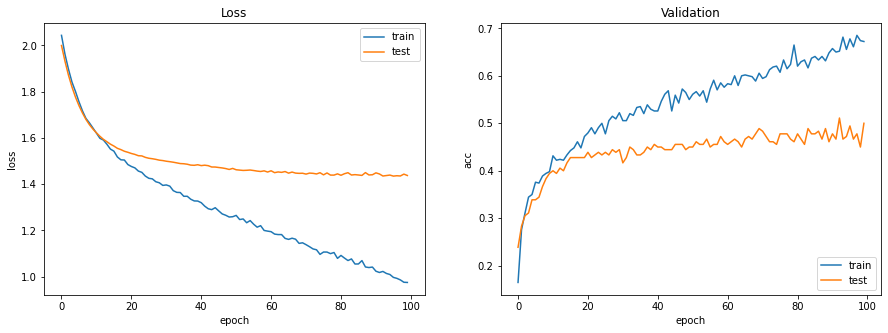

In [45]:

# Mostramos la grafica loss 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history_female.history['loss'])
ax1.plot(history_female.history['val_loss'])
ax1.set_title('Loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train', 'test'], loc='upper right')

# Mostramos la grafica accuracy
ax2.plot(history_female.history['accuracy'])
ax2.plot(history_female.history['val_accuracy'])
ax2.set_title('Validation')
ax2.set(xlabel='epoch', ylabel='acc')

ax2.legend(['train', 'test'], loc='lower right')

In [46]:
# Evaluamos contra test
score = model.evaluate(X_test_female, female_Y_test, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

2/2 [==============================] - 0s 13ms/step - loss: 1.4372 - accuracy: 0.5000
Loss: 1.437193751335144 
Accuracy: 50.0%


#### Predicción

In [47]:
# Predecimos los valores a partir de los datos de test
y_pred = model.predict(X_test_female)
y_pred_class = np.argmax(y_pred, axis = 1)
y_true = np.argmax(female_Y_test, axis = 1)

In [48]:
# Sumamos 1 al rango [0,7] --> [1,8]
## Prediccion
y_pred_class.astype(int).flatten()
y_pred_class = np.add(y_pred_class, 1).tolist()
## Valor esperado
y_true = np.add(y_true, 1).tolist()

In [49]:
data_prediction = {'Predicted':y_pred_class, 'Expected': y_true}
df = pd.DataFrame(data_prediction, columns=['Predicted', 'Expected']).replace(EMOTION_MAP)
displayed = shuffle(df)
displayed.head(10)

,Predicted,Expected
65,calma,sorpresa
76,calma,calma
52,tristeza,enfado
95,miedo,tristeza
57,sorpresa,calma
123,tristeza,tristeza
93,asco,asco
2,neutral,neutral
70,sorpresa,calma
27,tristeza,enfado


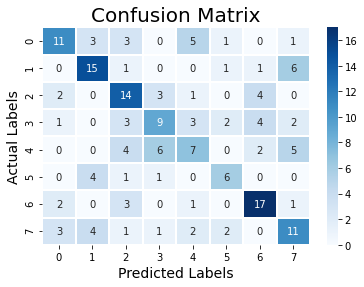

In [50]:
cm = confusion_matrix(y_true, y_pred_class)
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

### **4.2 ENTRENAMIENTO CON _MALE_**

#### Compilación

In [60]:
# male_X_train, male_X_test, male_Y_train, male_Y_test
model = model_cnn(X_train_male, male_Y_test.shape[1])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 216, 128)          768       
_________________________________________________________________
activation_9 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 27, 128)           82048     
_________________________________________________________________
activation_10 (Activation)   (None, 27, 128)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 27, 128)          

In [61]:
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])

# X_train_male, X_test_male
# Callbacks para tratar el overfitting
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 15)

history_male = model.fit(X_train_male, male_Y_train, 
                        batch_size=16, 
                        epochs=100, 
                        validation_data=(X_test_male, male_Y_test),
                        callbacks=[rlrp])

# Guardamos el modelo
model.save('1_model_ravdess_male_SER.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
34/34 [==============================] - 2s 30ms/step - loss: 2.0671 - accuracy: 0.1796 - val_loss: 2.0039 - val_accuracy: 0.2222
Epoch 2/100
34/34 [==============================] - 1s 20ms/step - loss: 1.9922 - accuracy: 0.2160 - val_loss: 1.9592 - val_accuracy: 0.2500
Epoch 3/100
34/34 [==============================] - 1s 20ms/step - loss: 1.9285 - accuracy: 0.2561 - val_loss: 1.9234 - val_accuracy: 0.2500
Epoch 4/100
34/34 [==============================] - 1s 20ms/step - loss: 1.9002 - accuracy: 0.2739 - val_loss: 1.8941 - val_accuracy: 0.2444
Epoch 5/100
34/34 [==============================] - 1s 20ms/step - loss: 1.8460 - accuracy: 0.2855 - val_loss: 1.8738 - val_accuracy: 0.2444
Epoch 6/100
34/34 [==============================] - 1s 20ms/step - loss: 1.7923 - accuracy: 0.3097 - val_loss: 1.8591 - val_accuracy: 0.2556
Epoch 7/100
34/34 [==============================] - 1s 20ms/step - loss: 1.7916 - accuracy: 0.3372 - val_loss: 1.8452 - val_accuracy: 0.2667
Epoch 

#### Validación del modelo

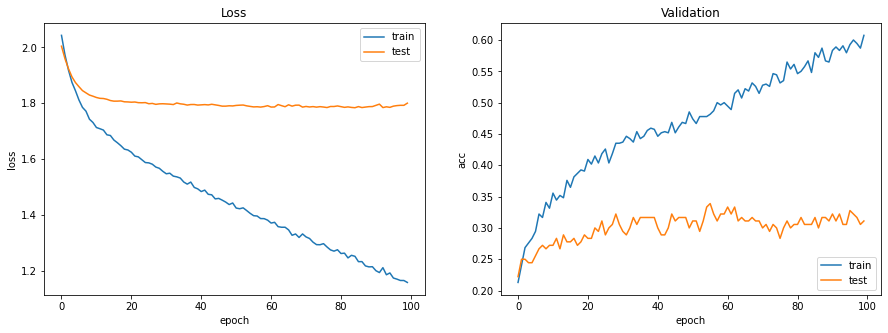

In [62]:
# Mostramos la grafica loss 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history_male.history['loss'])
ax1.plot(history_male.history['val_loss'])
ax1.set_title('Loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train', 'test'], loc='upper right')

# Mostramos la grafica accuracy
ax2.plot(history_male.history['accuracy'])
ax2.plot(history_male.history['val_accuracy'])
ax2.set_title('Validation')
ax2.set(xlabel='epoch', ylabel='acc')

ax2.legend(['train', 'test'], loc='lower right')

In [64]:
# Evaluamos contra test
score = model.evaluate(X_test_male, male_Y_test, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

2/2 [==============================] - 0s 18ms/step - loss: 1.8002 - accuracy: 0.3111
Loss: 1.8001708984375 
Accuracy: 31.111112236976624%


#### Predicción

In [66]:
# Predecimos los valores a partir de los datos de test
y_pred = model.predict(X_test_male)
y_pred_class = np.argmax(y_pred, axis = 1)
y_true = np.argmax(male_Y_test, axis = 1)

In [67]:
# Sumamos 1 al rango [0,7] --> [1,8]
## Prediccion
y_pred_class.astype(int).flatten()
y_pred_class = np.add(y_pred_class, 1).tolist()
## Valor esperado
y_true = np.add(y_true, 1).tolist()

In [68]:
data_prediction = {'Predicted':y_pred_class, 'Expected': y_true}
df = pd.DataFrame(data_prediction, columns=['Predicted', 'Expected']).replace(EMOTION_MAP)
displayed.sample(10)

,Predicted,Expected
155,neutral,asco
71,neutral,neutral
139,asco,tristeza
138,tristeza,tristeza
120,felicidad,tristeza
14,miedo,miedo
74,sorpresa,asco
19,sorpresa,tristeza
164,felicidad,neutral
73,felicidad,enfado


### **4.3 ENTRENAMIENTO CON EL DATASET COMPLETO**

#### Compilación

In [69]:
# X_train, X_test, Y_train, Y_test
model = model_cnn(X_train, Y_train.shape[1])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 216, 128)          768       
_________________________________________________________________
activation_12 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 27, 128)           82048     
_________________________________________________________________
activation_13 (Activation)   (None, 27, 128)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 27, 128)          

In [70]:
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])


# Callbacks para tratar el overfitting
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 15)

history = model.fit(X_train, Y_train, 
                        batch_size=16, 
                        epochs=100, 
                        validation_data=(X_test, Y_test),
                        callbacks=[rlrp])

# Guardamos el modelo
model.save('1_model_ravdess_complete_SER.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
68/68 [==============================] - 3s 25ms/step - loss: 2.0403 - accuracy: 0.1916 - val_loss: 1.9758 - val_accuracy: 0.2389
Epoch 2/100
68/68 [==============================] - 1s 19ms/step - loss: 1.9591 - accuracy: 0.2597 - val_loss: 1.9150 - val_accuracy: 0.2389
Epoch 3/100
68/68 [==============================] - 1s 19ms/step - loss: 1.8745 - accuracy: 0.2816 - val_loss: 1.8790 - val_accuracy: 0.2500
Epoch 4/100
68/68 [==============================] - 1s 19ms/step - loss: 1.8353 - accuracy: 0.2924 - val_loss: 1.8528 - val_accuracy: 0.2556
Epoch 5/100
68/68 [==============================] - 1s 19ms/step - loss: 1.8140 - accuracy: 0.3114 - val_loss: 1.8339 - val_accuracy: 0.2639
Epoch 6/100
68/68 [==============================] - 1s 19ms/step - loss: 1.7988 - accuracy: 0.3266 - val_loss: 1.8212 - val_accuracy: 0.2611
Epoch 7/100
68/68 [==============================] - 1s 20ms/step - loss: 1.7809 - accuracy: 0.3433 - val_loss: 1.8124 - val_accuracy: 0.2833
Epoch 

#### Validación del modelo

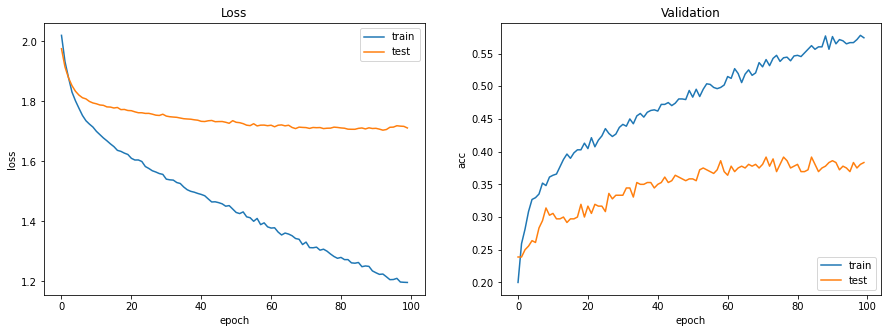

In [71]:
# Mostramos la grafica loss 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train', 'test'], loc='upper right')

# Mostramos la grafica accuracy
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Validation')
ax2.set(xlabel='epoch', ylabel='acc')

ax2.legend(['train', 'test'], loc='lower right')

In [72]:
# Evaluamos contra test
score = model.evaluate(X_test, Y_test, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

3/3 [==============================] - 0s 20ms/step - loss: 1.7116 - accuracy: 0.3833
Loss: 1.7115929126739502 
Accuracy: 38.333332538604736%


Predicción

In [73]:
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis = 1)
y_true = np.argmax(Y_test, axis = 1)

In [74]:
# Sumamos 1 al rango [0,7] --> [1,8]
## Prediccion
y_pred_class.astype(int).flatten()
y_pred_class = np.add(y_pred_class, 1).tolist()
## Valor esperado
y_true = np.add(y_true, 1).tolist()

In [75]:
data_prediction = {'Predicted':y_pred_class, 'Expected': y_true}
df = pd.DataFrame(data_prediction, columns=['Predicted', 'Expected']).replace(EMOTION_MAP)
displayed.sample(10)

,Predicted,Expected
122,calma,neutral
65,calma,sorpresa
87,felicidad,felicidad
14,miedo,miedo
63,sorpresa,enfado
107,tristeza,felicidad
54,enfado,tristeza
30,neutral,neutral
56,neutral,neutral
149,neutral,sorpresa
